# base_model

> In this module we have the base model, learner and other things we need to train encoder
 

In [64]:
#| default_exp base_model

In [65]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

Here we have the base functions and classes to train a basic BT-style model. Note that this (mostly) all comes directly from here: `https://github.com/KeremTurgutlu/self_supervised/blob/main/nbs/14%20-%20barlow_twins.ipynb`
but we needed to extend some of the functionality for our purposes. 

Some of the base classes and functions needed for image augmentation pipeline:

In [67]:
#| export

#My edited version of RandTransform
class RandomGaussianBlur(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, 
                 p=1.0, #debugging (bug in libraries implementation)
                 prob=0.5,#the real probability
                 s=(8,32), #kernel
                 sig=None, #sig_val is either manually input OR
                 blur_r=(0.1,2),#is randomly chosen from uniform with these bounds
                 same_on_batch=False, 
                 **kwargs): 
        
        store_attr()
        super().__init__(p=p, **kwargs)

    def encodes(self, x:TensorImage):
        
        if isinstance(self.s, int):   s = (self.s,self.s)
        elif isinstance(self.s, tuple) or isinstance(self.s, list): s=self.s
     
        #Default for ImageNet from BYOL / BT papers
        if self.sig is None:
            sig_val = np.random.uniform(self.blur_r[0],self.blur_r[1])
        
        else:
            sig_val = self.sig
            

        tfm = korniatfm.RandomGaussianBlur(kernel_size=s,sigma=(sig_val,sig_val),same_on_batch=self.same_on_batch,p=self.prob)
        return tfm(x)

#Delete later: leaving for backward compatibility for now
# class RandomGaussianBlur(RandTransform):
#     "Randomly apply gaussian blur with probability `p` with a value of s"
#     order = 11
#     def __init__(self, p=0.5, s=(8,32), same_on_batch=False, **kwargs): 
#         store_attr()
#         super().__init__(p=p, **kwargs)
        
#     def encodes(self, x:TensorImage):
#         if isinstance(self.s, tuple): s = np.random.randint(*self.s)
#         if isinstance(self.s, list):  s = np.random.randint(*self.s)
#         if isinstance(self.s, int):   s = self.s
#         s2 = int(s/4)*2+1
#         tfm = korniatfm.RandomGaussianBlur((s2,s2),(s,s),same_on_batch=self.same_on_batch,p=1.) #p=1. is a bug
#                                             #kernel #sigma
        
#         return tfm(x)


class RandomCenterDropout(torch.nn.Module):
    def __init__(self, p=0.5, min_dropout_size=(20, 20), max_dropout_size=(60, 60), fill_value=0, same_on_batch=False):
        super().__init__()
        self.p = p
        self.min_dropout_size = min_dropout_size
        self.max_dropout_size = max_dropout_size
        self.fill_value = fill_value
        self.same_on_batch = same_on_batch
        #self.id_transform = tvtfm.RandomResizedCrop((256, 256), scale=(1.,1.), ratio=(1.,1.))


    def forward(self, x):
        # Check if the augmentation should be applied to the whole batch or individually

        #x=self.id_transform(x)

        if self.same_on_batch:
            if random.random() < self.p:
                return self._apply_dropout(x)
            else:
                return x
        else:
            # Apply dropout individually with given probability
            for i in range(x.size(0)):
                tem=random.random()
                #print(f"tem is: {tem}")
                if tem < self.p:
                    x[i] = self._apply_dropout(x[i].unsqueeze(0)).squeeze(0)
            return x

    def _apply_dropout(self, img):
        for i,count in enumerate(range(img.size(0))):  # Iterate through batch if necessary
            _, h, w = img[i].shape
            # Generate random dropout size within specified limits
            dh = random.randint(self.min_dropout_size[0], self.max_dropout_size[0])
            dw = random.randint(self.min_dropout_size[1], self.max_dropout_size[1])
            
            x1 = int(max((w - dw) / 2, 0))
            y1 = int(max((h - dh) / 2, 0))
            
            mask = torch.ones_like(img[i])
            mask[:, y1:y1+dh, x1:x1+dw] = self.fill_value
            img[i] = img[i] * mask
        
        return img

    
def get_BT_batch_augs(size,
                    flip=True,crop=True,noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True,cutout=False, #Whether to use  given aug or not
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),#hps of diff augs
                    blur_r=(0.1,2),blur_sig=None,sol_t=0.05,sol_a=0.05,min_dropout_size=(25, 100),max_dropout_size=(50,150), #hps of diff augs
                    flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1,cut_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[]
                    ):
    "Input batch augmentations implemented in tv+kornia+fastai"
    
    tfms = []

    korniatfm.RandomHorizontalFlip.order = RandomResizedCrop.order-1


    if crop: tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    #Unfortunately for some reason this doesn't work, so we can't apply "same_on_batch=False"
    #tfms += [korniatfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio, same_on_batch=same_on_batch)]

    if cutout: tfms+=[RandomCenterDropout(min_dropout_size=min_dropout_size,max_dropout_size=max_dropout_size, fill_value=0, p=cut_p,same_on_batch=same_on_batch)]
    
  
    if flip: tfms += [korniatfm.RandomHorizontalFlip(p=flip_p,same_on_batch=same_on_batch)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

                                             #brightness,contrast,saturation,hue
    if jitter: tfms += [korniatfm.ColorJitter(0.4*jitter_s, 0.4*jitter_s, 0.2*jitter_s, 0.1*jitter_s, p=jitter_p, same_on_batch=same_on_batch)]
    
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]
        
    #sig will usually be None
    if blur:   tfms += [RandomGaussianBlur(prob=blur_p, s=blur_s,sig=blur_sig,blur_r=blur_r, same_on_batch=same_on_batch)]

    korniatfm.RandomSolarize.order = RandomGaussianBlur.order + 1 #we want to apply solarization after RandomGaussianBlur
    
    if solar: tfms += [korniatfm.RandomSolarize(p=sol_p,thresholds=sol_t, additions=sol_a,same_on_batch=same_on_batch)]

    if noise: tfms+=[korniatfm.RandomGaussianNoise(mean=0.0, std=noise_std, same_on_batch=same_on_batch, p=noise_p)]
    
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms

    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

@delegates(get_BT_batch_augs)
def get_multi_aug_pipelines(size, **kwargs): return get_BT_batch_augs(size, **kwargs)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(size=size,**kwargs)


In [68]:
#| export

def get_bt_cifar10_aug_pipelines(size):
    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                                                    bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                    resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
                                                    bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.5,sol_p=0.0,
                                                    stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                    )

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                                                    bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                    resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
                                                    bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.1,sol_p=0.2,
                                                    stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                    )

    bt_cifar10_aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

    return bt_cifar10_aug_pipelines

#Add other augmentations here e.g. BYOL augs
IMAGENET_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,cut_p=0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1,min_dropout_size=None,max_dropout_size=None,
                )

DERMNET_Augs = IMAGENET_Augs.copy()
DERMNET_Augs['min_dropout_size']=(50, 185)
DERMNET_Augs['max_dropout_size']=(100,190)
DERMNET_Augs['cut_p']=0.5

def helper_get_bt_augs(size,Augs=IMAGENET_Augs):


    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True,cutout=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        min_dropout_size=Augs['min_dropout_size'],max_dropout_size=Augs['max_dropout_size'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'],cut_p=Augs['cut_p'], #prob of performing aug
                        same_on_batch=False,stats=None)

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True,cutout=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        min_dropout_size=Augs['min_dropout_size'],max_dropout_size=Augs['max_dropout_size'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'],cut_p=Augs['cut_p'], #prob of performing aug
                        same_on_batch=False,stats=None)

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

    return aug_pipelines

def get_bt_imagenet_aug_pipelines(size):
    return helper_get_bt_augs(size,Augs=IMAGENET_Augs)

def get_bt_dermnet_aug_pipelines(size):
    return helper_get_bt_augs(size,Augs=DERMNET_Augs)



bt_aug_func_dict = {'bt_cifar10_aug_pipelines':get_bt_cifar10_aug_pipelines,'bt_imagenet_aug_pipelines':get_bt_imagenet_aug_pipelines,
                   'bt_dermnet_aug_pipelines':get_bt_dermnet_aug_pipelines
                   }

def get_bt_aug_pipelines(bt_augs,size):

    return bt_aug_func_dict[bt_augs](size)

    

In [69]:
#| export

def get_ssl_dls(dataset,#cifar10, dermnet, etc
            bs,
            size,
            device,
            pct_dataset=1.0):
    # Define the base package name in a variable for easy modification

    try:
        # Construct the module path
        module_path = f"{PACKAGE_NAME}.{dataset}_dataloading"
        
        # Dynamically import the module
        dataloading_module = importlib.import_module(module_path)
    except ModuleNotFoundError:
        # Handle the case where the module cannot be found
        raise ImportError(f"Could not find a data loading module for '{dataset}'. "
                          f"Make sure '{module_path}' exists and is correctly named.") from None
    
    # Assuming the function name follows a consistent naming convention
    func_name = f"get_bt_{dataset}_train_dls"

    try:
        # Retrieve the data loading function from the module
        data_loader_func = getattr(dataloading_module, func_name)
    except AttributeError:
        # Handle the case where the function does not exist in the module
        raise AttributeError(f"The function '{func_name}' was not found in '{module_path}'. "
                             "Ensure it is defined and named correctly.") from None
    
    # Proceed to call the function with arguments from the config
    try:
        dls_train = data_loader_func(bs=bs,size=size,device=device,pct_dataset=pct_dataset)
    except Exception as e:
        # Handle any errors that occur during the function call
        raise RuntimeError(f"An error occurred while calling '{func_name}' from '{module_path}': {e}") from None
    
    return dls_train


Base functions / classes we need to train a BT / RBT model.

In [70]:
#| export
#Base functions / classes we need to train a BT / RBT model.

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
# class BarlowTwinsModel(Module):
#     """An encoder followed by a projector
#     """
#     def __init__(self,encoder,projector):
#         self.encoder = encoder
#         self.projector = projector
        
#     def forward(self,x): 
        
#         return self.projector(self.encoder(x))

class BarlowTwinsModel(Module):
    """An encoder followed by a projector"""
    def __init__(self, encoder, projector, cache_size):
        self.encoder = encoder
        self.projector = projector
        self.cache_size = cache_size
        self.cached_outputs = []
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.projector(x)
        self.cached_outputs.append(x)
        
        if len(self.cached_outputs) == self.cache_size:
            concatenated_outputs = torch.cat(self.cached_outputs, dim=0)
            self.cached_outputs = []
            return concatenated_outputs
        else:
            return None

def create_barlow_twins_model(encoder,cache_size, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder=encoder, projector=projector,cache_size=cache_size)

# class BarlowTwins(Callback):
#     order,run_valid = 9,True
#     def __init__(self, aug_pipelines,n_in,lmb,sparsity_level, 
#                 model_type='barlow_twins',print_augs=False
#                  ):
#         assert_aug_pipelines(aug_pipelines)
#         self.aug1, self.aug2 = aug_pipelines
#         if print_augs: print(self.aug1), print(self.aug2)
#         store_attr('lmb')
#         store_attr('sparsity_level')
#         self.n_in=n_in
#         self.model_type = model_type
#         self.index=-1 #Gets updated after each batch
#         self.acc_dict = {}
        
#     def before_fit(self): 
#         self.learn.loss_func = self.lf
#         nf = self.learn.model.projector[-1].out_features
#         self.I = torch.eye(nf).to(self.dls.device)


#     def before_epoch(self):
#         self.index=-1  
  
#     def before_batch(self):
        
#         #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
#         #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
#         #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
#         if self.n_in == 1:

#             xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            
#             #print(xi.shape)
                                    
#         elif self.n_in == 3:
            
#             xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

#         self.learn.xb = (torch.cat([xi, xj]),)

#         self.index=self.index+1

class BarlowTwins(Callback):
    order, run_valid = 9, True
    def __init__(self, aug_pipelines, n_in, lmb, sparsity_level, model_type='barlow_twins', print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        store_attr('sparsity_level')
        self.n_in = n_in
        self.model_type = model_type
        self.index = -1  # Gets updated after each batch
        self.acc_dict = {}
        
    def before_fit(self):
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def before_batch(self):
        if self.n_in == 1:
            xi, xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
        elif self.n_in == 3:
            xi, xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (torch.cat([xi, xj]),)
        self.index += 1

    def after_loss(self):
        output = self.learn.model(self.learn.xb[0])
        if output is not None:
            self.learn.loss = self.lf(output, self.I)
        else:
            self.learn.loss = None
        
    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [71]:
# #| export
# #We want access to both representation and projection for variations 

class BarlowTwinsModel(Module):
    """An encoder followed by a projector"""
    def __init__(self, encoder, projector, cache_size):
        self.encoder = encoder
        self.projector = projector
        self.cache_size = cache_size
        self.cached_outputs = []

    def forward(self, x):
        tem = self.encoder(x)
        proj = self.projector(tem)
        self.cached_outputs.append((tem, proj))

        if len(self.cached_outputs) == self.cache_size:
            cached_tem, cached_proj = zip(*self.cached_outputs)
            self.cached_outputs = []
            return torch.cat(cached_tem), torch.cat(cached_proj)
        else:
            return None

    def __str__(self):
        return 'forward returns tuple of (encoder(x), projector(encoder(x))) when cache is full, otherwise None'

def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3, cache_size=1):
    "Create Barlow Twins model with caching mechanism"
    n_in = in_channels(encoder)
    with torch.no_grad():
        representation = encoder(torch.randn((2, n_in, 128, 128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector, cache_size=cache_size)

Here we write down standard definition of `lf` for `RAT` method: 

BarlowTwins needs an `lf` method to work properly. Here we provide the `lf` of standard barlow twins. Later we can
patch in a new defintion of `lf` that involves random functions, inner maximization etc. The tools needed to do this are provised in `base_lf`

In [72]:
#| export
def lf_bt(pred,I,lmb):
    bs,nf = pred.size(0)//2,pred.size(1)
    
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    loss = (cdiff*I + cdiff*(1-I)*lmb).sum() 
    return loss

In [73]:
#| export
def lf_bt_indiv_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]

    sparsity = lmb*(0.5*torch.abs(z1_enc) + 0.5*torch.abs(z2_enc)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

    


In [74]:
#| export
def lf_bt_group_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]

    sparsity = lmb * ((0.5 * z1_enc.pow(2) + 0.5 * z2_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [75]:
#| export
def lf_bt_group_norm_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    

    eps = 1e-7
    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / (z1_enc.std(0, unbiased=False)+eps)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / (z2_enc.std(0, unbiased=False)+eps)

    sparsity = lmb * ((0.5 * z1norm_enc.pow(2) + 0.5 * z2norm_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [76]:
#| export
def lf_bt_fun(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    

    eps = 1e-7
    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / (z1_enc.std(0, unbiased=False)+eps)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / (z2_enc.std(0, unbiased=False)+eps)

    sparsity = lmb * ((0.5 * z1norm_enc.pow(2) + 0.5 * z2norm_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm_enc.T @ z2norm_enc) / bs
    cdiff = (C - I)**2

    loss = (cdiff*I).sum() #standard bt loss

    print(f"invariance loss is: {loss} and sparsity loss is: {sparsity}")

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [77]:
#| export
def lf_bt_proj_group_sparse(pred,I,lmb,sparsity_level,
                           ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    sparsity = lmb * ((0.5 * z1norm.pow(2) + 0.5 * z2norm.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [78]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb):
    "Assumes model created according to type p3"


    if pred is None:
        return None

    if self.model_type=='barlow_twins':
         pred_enc = pred[0]
         pred = pred[1]
         return lf_bt(pred, self.I,self.lmb)

    elif self.model_type=='indiv_sparse_barlow_twins':
        return lf_bt_indiv_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)
    
    elif self.model_type=='group_sparse_barlow_twins':
        return lf_bt_group_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)

    elif self.model_type=='group_norm_sparse_barlow_twins':
        return lf_bt_group_norm_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)

    elif self.model_type=='proj_group_sparse_barlow_twins':
        return lf_bt_proj_group_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)
    
    elif self.model_type=='fun':
        return lf_bt_fun(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)


    else: raise(Exception)

In [79]:
#| export
def my_splitter_bt(m):
    return L(sequential(*m.encoder),m.projector).map(params)

Here we show how to use the above functions in an end to end fashion. First we get some data and plonk it into a dls, Then create an encoder, an augmentation pipeline, a learner, then fit
the learner. This is the complete process of training BT. 

In [80]:
#| export
def show_bt_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwins(aug,n_in=n_in,lmb=None,sparsity_level=None,
                                                     print_augs=print_augs
                                        )])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins.show(n=n)

In [81]:
#| export
class SaveBarlowLearnerCheckpoint(Callback):
    "Save such that can resume training "
    def __init__(self, experiment_dir,start_epoch=0, save_interval=250,with_opt=True):
        self.experiment_dir = experiment_dir
        self.start_epoch = start_epoch
        self.save_interval = save_interval
        self.with_opt = with_opt  # Decide whether to save optimizer state as well.

    def after_epoch(self):
        if (self.epoch+1) % self.save_interval == 0 and self.epoch>=self.start_epoch:
            print(f"Saving model and learner state at epoch {self.epoch}")
   
            checkpoint_filename = f"learner_checkpoint_epoch_{self.epoch}"
            checkpoint_path = os.path.join(self.experiment_dir, checkpoint_filename)
            # Save the entire learner object, including the model's parameters and optimizer state.
            self.learn.save(checkpoint_path, with_opt=self.with_opt)
            print(f"Checkpoint saved to {checkpoint_path}")

class SaveBarlowLearnerModel(Callback):
    def __init__(self, experiment_dir):
        self.experiment_dir = experiment_dir

    def after_fit(self):
        model_filename = f"trained_model_epoch_{self.epoch}.pth"
        model_path = os.path.join(self.experiment_dir, model_filename)
        torch.save(self.learn.model.state_dict(), model_path)
        print(f"Model state dict saved to {model_path}")

        encoder_filename = f"trained_encoder_epoch_{self.epoch}.pth"
        encoder_path = os.path.join(self.experiment_dir, encoder_filename)
        torch.save(self.learn.model.encoder.state_dict(), encoder_path)
        print(f"encoder state dict saved to {encoder_path}")


In [82]:
#| export
def load_barlow_model(arch,ps,hs,path):

    encoder = resnet_arch_to_encoder(arch=arch, weight_type='random')
    model = create_barlow_twins_model(encoder, hidden_size=hs, projection_size=ps)
    model.load_state_dict(torch.load(path))

    return model


    

In [83]:
#| export

class BarlowTrainer:
    "Setup a learner for training a BT model. Can do transfer learning, normal training, or resume training."

    def __init__(self,
                 model,#An encoder followed by a projector
                 dls,
                 bt_aug_pipelines,
                 lmb,
                 sparsity_level,
                 n_in,
                 model_type,
                 wd,
                 device,
                 num_it=100, #Number of iterations to run lr_find for.
                 load_learner_path=None, #Path to load learner from (optional)
                 experiment_dir=None, #Where to save model checkpoints (optional)
                 start_epoch=0, #Which epoch to start from
                 save_interval=None, #How often to save model checkpoints (optional). 
                 export=False,
                 ):

        store_attr()
        self.learn = self.setup_learn()

    
    def setup_learn(self):
        """
        Sets up the learner with the model, callbacks, and metrics.

        Returns:
        - learn: The Learner object.
        """
      
        self.model.to(self.device)

        cbs = [BarlowTwins(self.bt_aug_pipelines,n_in=self.n_in,lmb=self.lmb,
                           sparsity_level=self.sparsity_level,print_augs=False,
                           model_type=self.model_type
                           )
              ]

        learn=Learner(self.dls,self.model,splitter=my_splitter_bt,wd=self.wd, cbs=cbs
                     )
        
        if self.load_learner_path: learn.load(self.load_learner_path,with_opt=True)

        return learn
    
    def _get_training_cbs(self,interrupt_epoch):
        "Add train-time cbs to learner. Note e.g. we don't want these in operation when we're doing lr_find."

        
        cbs=[InterruptCallback(interrupt_epoch)]
        
        if self.experiment_dir:
            cbs.append(SaveBarlowLearnerCheckpoint(experiment_dir=self.experiment_dir,
                                             start_epoch = self.start_epoch,
                                             save_interval=self.save_interval,
                                             )
                      )
        
        if self.export:
            cbs.append(SaveBarlowLearnerModel(experiment_dir=self.experiment_dir))
   
        return cbs
                
    
    def bt_transfer_learning(self,freeze_epochs:int,epochs:int,interrupt_epoch:int):
        """If the encoder is already pretrained, we can do transfer learning.
            Freeze encoder, train projector for a few epochs, then unfreeze and train all. 
        """

        self.learn.freeze()
        test_grad_off(self.learn.encoder)
        self.learn.fit(freeze_epochs)
        self.learn.unfreeze()
        test_grad_on(self.learn.model)
        lrs = self.learn.lr_find(num_it=self.num_it)

        
        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs(interrupt_epoch)
                                )

    def bt_learning(self,epochs:int,interrupt_epoch:int):
        """If the encoder is not pretrained, we can do normal training.
        """

        lrs = self.learn.lr_find(num_it=self.num_it)

        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs(interrupt_epoch))
    
    def continue_bt_learning(self,epochs:int,start_epoch:int,interrupt_epoch:int):
        """Resume training with `fit_one_cycle` after loading a learner.
        """
        
        test_ne(self.load_learner_path,None)

        self.learn.fit_one_cycle(epochs,start_epoch=start_epoch,cbs=self._get_training_cbs(interrupt_epoch))

    def train(self,learn_type, freeze_epochs:int,epochs:int,start_epoch:int,interrupt_epoch:int):
        """Train model using BT
        """
        if learn_type == 'transfer_learning':
            
            self.bt_transfer_learning(freeze_epochs=freeze_epochs,epochs=epochs,interrupt_epoch=interrupt_epoch)

        elif learn_type=='continue_learning':
            self.continue_bt_learning(epochs=epochs,start_epoch=start_epoch,interrupt_epoch=interrupt_epoch)
        
        elif learn_type=='standard':
            self.bt_learning(epochs=epochs,interrupt_epoch=interrupt_epoch)

        else: raise Exception("Invalid weight_type")

        return self.learn


In [84]:
#| export

def main_bt_train(config,
        start_epoch = 0,
        interrupt_epoch = 100,
        load_learner_path=None,
        learn_type = 'standard', #can be 'standard', 'transfer_learning', or 'continue_learning'
        experiment_dir=None,
        ):
    "Basically map from config to training a BT model. Optionally save checkpoints of learner, to reload and continue;"



    # Initialize the device for model training (CUDA or CPU)
    device = default_device()

    # Construct the model based on the configuration
    # This involves selecting the architecture and setting model-specific hyperparameters.
    encoder = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)
    
    model = create_barlow_twins_model(encoder,cache_size=config.cache_size, hidden_size=config.hs, projection_size=config.ps)

    # Prepare data loaders according to the dataset specified in the configuration
    dls = get_ssl_dls(dataset=config.dataset, bs=config.bs,size=config.size, device=device,pct_dataset=config.pct_dataset)

    # Set up data augmentation pipelines as specified in the configuration
    bt_aug_pipelines = get_bt_aug_pipelines(bt_augs=config.bt_augs, size=config.size)

    # Train the model with the specified configurations and save `learn` checkpoints

    if experiment_dir and config.epochs == interrupt_epoch:
        export=True
    else:
        export=False

    #Setup the bt trainer. basically a `Learner` with a few extra bells and whistles
    bt_trainer = BarlowTrainer(model=model,
                    dls=dls,
                    bt_aug_pipelines=bt_aug_pipelines,
                    lmb=config.lmb,
                    sparsity_level=config.sparsity_level,
                    n_in=config.n_in,
                    model_type=config.model_type,
                    wd=config.wd,
                    num_it=config.num_it,
                    device=device,
                    load_learner_path=load_learner_path,
                    experiment_dir=experiment_dir,
                    start_epoch=start_epoch,
                    save_interval=config.save_interval,
                    export=export
                                    )

    # Train the model with the specified configurations and save `learn` checkpoints
    learn = bt_trainer.train(learn_type=learn_type,freeze_epochs=config.freeze_epochs,epochs=config.epochs,start_epoch=start_epoch,interrupt_epoch=interrupt_epoch)
    return learn


In [85]:
# config_path = '../configs/cifar10/bt_test_config.yaml'
# config = load_config(config_path)

# load_learner_path=None
# experiment_dir=None
# start_epoch=0


# # Initialize the device for model training (CUDA or CPU)
# device = default_device()

# # Construct the model based on the configuration
# # This involves selecting the architecture and setting model-specific hyperparameters.
# encoder = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)

# model = create_barlow_twins_model(encoder, hidden_size=config.hs, projection_size=config.ps)

# # Prepare data loaders according to the dataset specified in the configuration
# dls = get_ssl_dls(dataset=config.dataset, bs=config.bs,size=config.size, device=device,pct_dataset=config.pct_dataset)

# # Set up data augmentation pipelines as specified in the configuration
# bt_aug_pipelines = get_bt_aug_pipelines(bt_augs=config.bt_augs, size=config.size)

# # Train the model with the specified configurations and save `learn` checkpoints

# #Setup the bt trainer. basically a `Learner` with a few extra bells and whistles
# bt_trainer = BarlowTrainer(model=model,
#                dls=dls,
#                bt_aug_pipelines=bt_aug_pipelines,
#                lmb=config.lmb,
#                sparsity_level=config.sparsity_level,
#                n_in=config.n_in,
#                model_type=config.model_type,
#                wd=config.wd,
#                num_it=config.num_it,
#                device=device,
#                load_learner_path=load_learner_path,
#                experiment_dir=experiment_dir,
#                start_epoch=start_epoch,
#                save_interval=config.save_interval
#                               )


# bt_trainer.learn.lr_find??

In [86]:
#| export

def get_bt_experiment_state(config,base_dir):
    """Get the load_learner_path, learn_type, start_epoch, interrupt_epoch for BT experiment.
       Basically this tells us how to continue learning (e.g. we have run two sessions for 
       100 epochs, and want to continue for another 100 epochs). Return values are
       None if we are starting from scratch.
    """

    load_learner_path, _  = get_highest_num_path(base_dir, config)
    #TODO:
    #We can get start_epoch, interrupt epoch from `get_highest_epoch_path` + save_interval (may be None!)
    start_epoch=0 if load_learner_path is None else int(load_learner_path.split('_')[-1])+1
    
    if start_epoch >= config.epochs:
        print(f"start_epoch={start_epoch}, but already completed {config.epochs} epochs. Exiting.")
        sys.exit()

    interrupt_epoch = start_epoch + config.save_interval

    #We can also get the learn_type from the load_learner_path + weight_type. 
    
    if config.weight_type == 'random':
        learn_type = 'standard'
    
    elif 'pretrained' in config.weight_type:
        learn_type = 'transfer_learning'

    learn_type = learn_type if load_learner_path is None else 'continue_learning'

    return load_learner_path, learn_type, start_epoch, interrupt_epoch

In [87]:
#| export

def main_bt_experiment(config,
                      base_dir,
                      ):
    """Run several epochs of the experiment as defined in the config and where we are up to. e.g. epoch 0, or resuming
    at epoch 99 etc. Basically a stateful version of `main_bt_train` that can be resumed. And saving.
    """
    
        
    experiment_dir, experiment_hash,git_commit_hash = setup_experiment(config,base_dir)

    load_learner_path, learn_type, start_epoch, interrupt_epoch = get_bt_experiment_state(config,base_dir)

    main_bt_train(config=config,
            start_epoch=start_epoch,
            interrupt_epoch=interrupt_epoch,
            load_learner_path=load_learner_path,
            learn_type=learn_type,
            experiment_dir=experiment_dir,
            )

    # Save a metadata file in the experiment directory with the Git commit hash and other details
    save_metadata_file(experiment_dir=experiment_dir, git_commit_hash=git_commit_hash)

    # After experiment execution and all processing are complete
    update_experiment_index(base_dir,{
        "experiment_hash": experiment_hash,  # Unique identifier derived from the experiment's configuration
        "experiment_dir": experiment_dir,  # Absolute path to the experiment's dedicated directory
        "git_commit_hash": git_commit_hash,  # Git commit hash for the code version used in the experiment
        # Potentially include additional details collected during or after the experiment, such as:
        # Any other metadata or results summary that is relevant to the experiment
                            })
    
    return experiment_dir,experiment_hash #Return the experiment_dir so we can easily access the results of the experiment


Full example.

The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e and the experiment hash is: 00ff5d7e
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/config.yaml
The git hash is: c57f28c0f63f5d1d939a24f40d27ad5691ba8db3
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e for highest num saved


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,247.061020,None,00:02
1,232.844116,None,00:01
2,238.653732,None,00:01
3,239.056427,None,00:01
4,238.287918,None,00:01
5,244.675537,None,00:01


Saving model and learner state at epoch 5
Checkpoint saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/learner_checkpoint_epoch_5
Interrupting training before starting epoch 6
Metadata saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/metadata.yaml
Updated experiment index for hash: 00ff5d7e
['learner_checkpoint_epoch_5.pth', 'metadata.yaml', 'config.yaml']
['SSL', 'experiment_index.json']
experiment_dir and base_dir
We can keep training - resuming from the checkpoint
The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e and the experiment hash is: 00ff5d7e
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/config.yaml
The git hash is: c57f28c0f63f5d1d939a24f40d27ad5691ba8db3
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres

/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Saving model and learner state at epoch 11
Checkpoint saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/learner_checkpoint_epoch_11
Model state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/trained_model_epoch_11.pth
encoder state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/trained_encoder_epoch_11.pth
Metadata saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/00ff5d7e/metadata.yaml
Updated experiment index for hash: 00ff5d7e
['learner_checkpoint_epoch_5.pth', 'trained_model_epoch_11.pth', 'metadata.yaml', 'config.yaml', 'learner_checkpoint_epoch_11.pth', 'trained_encoder_epoch_11.pth']
['SSL', 'experiment_index.json']
experiment_dir and base_dir
forward returns tuple of (encoder(x), projector(encoder(x))) when cache is full, otherwise None
The experiment_dir is: /var/folders/95

/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,282.821838,None,00:02
1,277.669891,None,00:03
2,251.806763,None,00:01
3,273.208832,None,00:01
4,263.365845,None,00:02
5,261.980682,None,00:02


Saving model and learner state at epoch 5
Checkpoint saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/edc2faf5/learner_checkpoint_epoch_5
Interrupting training before starting epoch 6
Metadata saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpyd2zhxbd/SSL/cifar10/smallres/edc2faf5/metadata.yaml
Updated experiment index for hash: edc2faf5


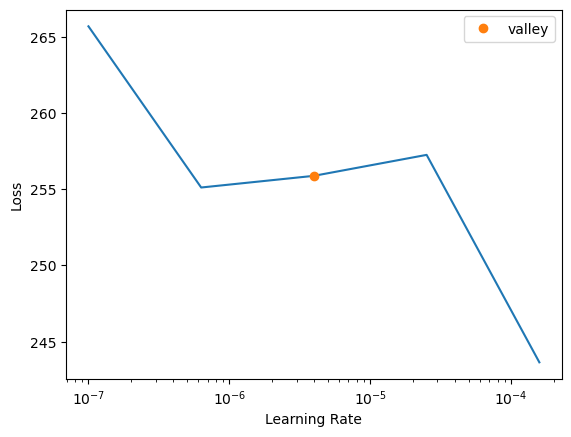

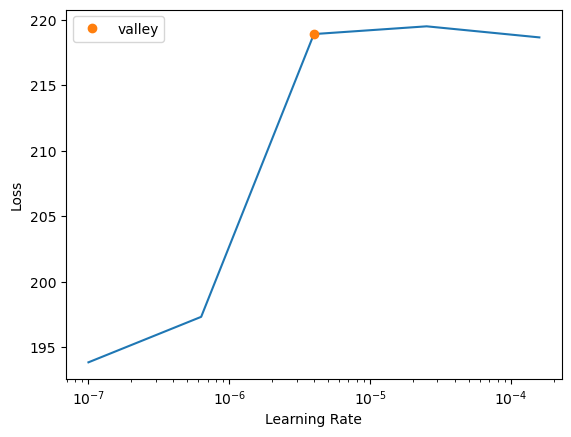

In [90]:
#| hide
with tempfile.TemporaryDirectory() as base_dir:
    
    config_path = '../configs/cifar10/bt_test_config.yaml'
    config = load_config(config_path)

    experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
    
    print(os.listdir(experiment_dir))
    print(os.listdir(base_dir))
    print('experiment_dir and base_dir')

    print('We can keep training - resuming from the checkpoint')

    experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
    print(os.listdir(experiment_dir))
    print(os.listdir(base_dir))
    print('experiment_dir and base_dir')

    #get path to fully fitted model
    path = os.path.join(experiment_dir,f'trained_model_epoch_{config.epochs-1}.pth')
    model = load_barlow_model(arch=config.arch,ps=config.ps,hs=config.hs,path=path)
    print(model)

    #New config but the first part of experiment_dir is same - just hash is different
    #It shouldnt find a max file path
    config.epochs=config.epochs+1
    experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)


    


In [89]:
#| hide
import nbdev; nbdev.nbdev_export()